In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

import time
%matplotlib inline

## 0. Together
TTS, KF, and LOO all aim to estimate the same thing: how a model will perform on unseen data, but they aren't necessarily equivalent (as you'll explore below). I mentioned in lecture that two major things you may want to think about when choosing a method of model validation are *computational expense of the model* and *the size of your dataset*.

I often get a lot of students who justify the use of TTS by saying that they were worried about computational expense. However, I hope to show you that except for extremely large datasets (we're talking 100's of thousands of rows), or incredibly complex models (which we won't really touch until the very end), in our class, computational expense between TTS and KF is often negligible and a weak argument for justifying TTS over KF/LOO.



In [3]:
# example of how to time code
start = time.perf_counter()

for i in range(0,1000000):
    10 + 10


stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")

it took 0.19841097699999466 seconds to run this code.


In [4]:
p = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/PopDivas_data.csv")
print(p.shape)
p.head()

(1599, 14)


,Unnamed: 0,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,track_name
0,1,Beyoncé,0.386,0.28800,1,-18.513,1,0.0602,0.533,0.01670,0.1410,0.399,43850,balance (mufasa interlude)
1,2,Beyoncé,0.484,0.36300,5,-8.094,0,0.0368,0.645,0.00000,0.1250,0.201,226479,BIGGER
2,3,Beyoncé,0.537,0.24700,2,-17.750,1,0.0793,0.199,0.00001,0.4230,0.170,46566,the stars (mufasa interlude)
3,4,Beyoncé,0.672,0.69600,4,-6.693,0,0.1770,0.200,0.02750,0.0736,0.642,162353,FIND YOUR WAY BACK
4,5,Beyoncé,0.000,0.00515,9,-22.612,0,0.0000,0.524,0.95000,0.1140,0.000,13853,uncle scar (scar interlude)


In [5]:
# Split Data
predictors = ["energy", "loudness", "mode", "speechiness",
              "acousticness", "instrumentalness", "liveness",
              "valence", "duration_ms"]


In [7]:
# TTS 80/20

start = time.perf_counter()

###
X_train, X_test, y_train, y_test = train_test_split(p[predictors], p["danceability"], test_size=0.2)

z = StandardScaler()
X_train[predictors] = z.fit_transform(X_train[predictors])
X_test[predictors] = z.transform(X_test[predictors])

lr = LinearRegression()

lr.fit(X_train, y_train)

###
stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")


it took 0.14125893300001735 seconds to run this code.


In [17]:
# KF 5
start = time.perf_counter()

###
X = p[predictors]
y = p["danceability"]
kf = KFold(5)

lr = LinearRegression()

for train,test in kf.split(X):
    X_train = X.loc[train]
    X_test = X.loc[test]
    y_train = y[train]
    y_test = y[test]
    
    lr.fit(X_train, y_train)

###
stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")


it took 0.02603074800003924 seconds to run this code.


In [18]:
# LOO
start = time.perf_counter()

###
X = p[predictors]
y = p["danceability"]

kf = LeaveOneOut()

lr = LinearRegression()

for train,test in kf.split(X):
    X_train = X.loc[train]
    X_test = X.loc[test]
    y_train = y[train]
    y_test = y[test]
    
    lr.fit(X_train, y_train)

###
stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")


it took 3.680277009000065 seconds to run this code.


In [8]:
# Define functions that can run our model validation simulation

def TTSSim():
    start = time.perf_counter()

    ###
    X_train, X_test, y_train, y_test = train_test_split(p[predictors], p["danceability"], test_size=0.2)

    z = StandardScaler()
    X_train[predictors] = z.fit_transform(X_train[predictors])
    X_test[predictors] = z.transform(X_test[predictors])

    lr = LinearRegression()

    lr.fit(X_train, y_train)

    ###
    stop = time.perf_counter()
    
    return(stop-start)

def KFSim():
    start = time.perf_counter()

    ###
    X = p[predictors]
    y = p["danceability"]
    kf = KFold(5)

    lr = LinearRegression()

    for train,test in kf.split(X):
        X_train = X.loc[train]
        X_test = X.loc[test]
        y_train = y[train]
        y_test = y[test]

        lr.fit(X_train, y_train)

    ###
    stop = time.perf_counter()
    
    return(stop-start)
    
def LOOSim():
    start = time.perf_counter()

    ###
    X = p[predictors]
    y = p["danceability"]

    kf = LeaveOneOut()

    lr = LinearRegression()

    for train,test in kf.split(X):
        X_train = X.loc[train]
        X_test = X.loc[test]
        y_train = y[train]
        y_test = y[test]

        lr.fit(X_train, y_train)

    ###
    stop = time.perf_counter()
    
    return(stop - start)

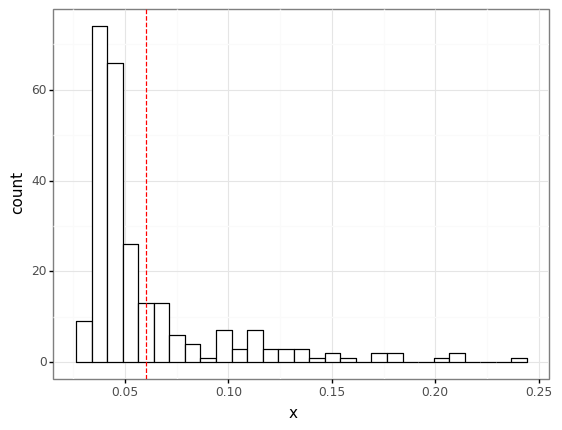

<ggplot: (8794879082228)>

In [9]:
tts = [TTSSim() for i in range(0,250)]

(ggplot(pd.DataFrame({"x": tts}), aes(x = "x")) +
 geom_histogram(fill = "white", color = "black") + theme_bw() +
 geom_vline(xintercept = np.mean(tts), color = "red", linetype = "dashed"))

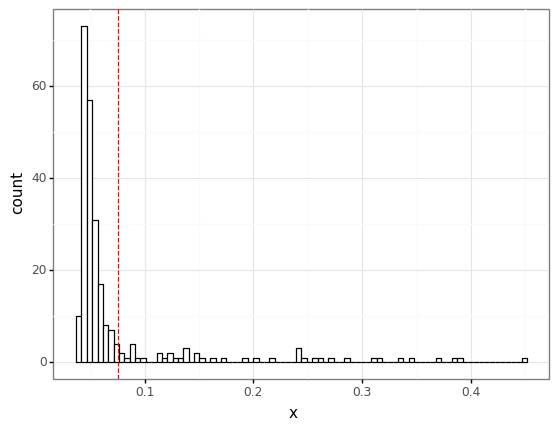

<ggplot: (8794879238428)>

In [10]:
kff = [KFSim() for i in range(0,250)]

(ggplot(pd.DataFrame({"x": kff}), aes(x = "x")) +
 geom_histogram(fill = "white", color = "black") + theme_bw() +
 geom_vline(xintercept = np.mean(kff), color = "red", linetype = "dashed"))

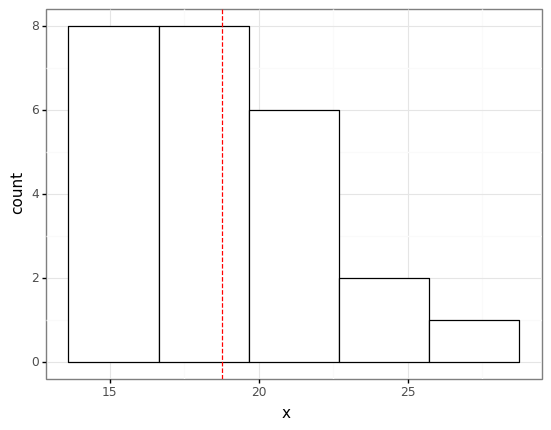

<ggplot: (8794879192745)>

In [11]:
loo = [LOOSim() for i in range(0,25)]

(ggplot(pd.DataFrame({"x": loo}), aes(x = "x")) +
 geom_histogram(fill = "white", color = "black") + theme_bw()+
 geom_vline(xintercept = np.mean(loo), color = "red", linetype = "dashed"))

## 1. Why K-Fold?

In the lecture we learned about 3 types of model validation: *Train-Test-Split*, *K-Fold*, and *Leave-One-Out* (which is just an extreme version of K-Fold).

TTS is easy, and computationally inexpensive, so why use K-Fold? One reason we discussed is that K-Fold allows you to use ALL your data in the test-set, and all your data in the training-set at (at least) one point.

Use the simulation below to look at how well TTS vs KF estimate the out-of-sample (test-set) error.

In [2]:
def modelValidationSim(n = 100):
    
    # Simulate Data---------------------------------------------------------------
    
    error_sd = 1
    # mean cat length in cm
    mean_length_cm = 170
    # standard deviation of cat length in cm
    sd_length_cm = 15
    
    # generate random data for cat length that follows a normal distribution
    length = np.random.normal(loc = mean_length_cm, scale = sd_length_cm, size = n)
    
    # weight = intercept + length*coefficient + random error
    weight = 0.2 + length*0.04 + np.random.normal(0,error_sd,n)
    
    #creates a df
    cats = pd.DataFrame({"length": length, "weight": weight})
    

    features = ["length"]
    X = cats[features]
    y = cats[["weight"]] #if you don't have the extra brackets, y will be a series instead of an array and throw an error
    
    ##############################################
    # Build a model using a Train Test Split with 20% (1/5th) of data in the test set
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    ##### Store the test-set MSE in the variable TTS
   
    model = LinearRegression() 
    
    #fitting test data into LR model
    model.fit(X_test, y_test) 
    
    #store test data MSE into TTS
    TTS = mean_squared_error(y_test, model.predict(X_test)) #real values, predicted values

    ##############################################
    # Build a model using a 5-Fold CV
    model2 = LinearRegression()
    KF_mse = []
   
    #creates 5 splits for model
    folder = KFold(n_splits = 5)
    
    for train,test in folder.split(X): 
        X_trainF = X.iloc[train] #grabbing x data frame using iloc ; X_trainF will only have testing data and vice versa
        X_testF = X.iloc[test] #Data frame
        y_trainF = y.iloc[train] #one vector
        y_testF = y.iloc[test]
        
        #model 
        KFmodel = model2.fit(X_testF, y_testF)

    # Store the average test-set MSE in the variable KF
    #add the mse from the KFmodel by comparing the y_testF (real values) to the predicted values using X_testF 
        KF_mse.append(mean_squared_error(y_testF, KFmodel.predict(X_testF))) 
    KF = np.mean(KF_mse)
    
    ##############################################
    
    # Return a dataframe with the KFold as one Column, and TrainTestSplit as the other (the df should have just 1 row)
    # (hint: If using pd.DataFrame() and a dictionary to create the df, make sure you put KF and TTS into
    # a list before setting them as a values for your dictionary)
    KFmodel_list = [KF]
    TTSmodel_list = [TTS]
    
    
    DF = pd.DataFrame({"KFold" : KFmodel_list, "TrainTestSplit" : TTSmodel_list})
    
    return (DF)
    ##############################################
    
modelValidationSim()


,KFold,TrainTestSplit
0,0.866397,1.141588


### *Question*

* In the cell below, use list comprehension to run this simulation 500 times.
* Then use ggplot to plot the histograms (or I highly recommend densities `geom_density(alpha = 0.4)` if you wanna get fancy) of the estimated MSE's from TTS vs KFold (look up `pd.melt()` to get your data in long form for this one)
* Plot a scatterplot of the TTS vs KFold estimates
* What patterns do you see? Is TTS systematically different from KFold? How could any differences you see affect your interpretation of TTS vs KF, or affect which you choose to use?
* Try changing `error_sd` (the standard deviation of the random error we add to the simulated data. The larger `error_sd` is, the more spread out data will be around the regression line), does this change the mean squared error estimates? Is there a certain pattern you can see?
* change `n` (the number of samples) to be 1000. Does this change anything? Change the difference between KF and TTS?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>

In [3]:
### YOUR CODE HERE ###
#run regression sumulation 500 times

cat500 = [modelValidationSim(n = 100) for x in range(0,500)]

#grab Kfold from cat500
KFold_DF = pd.concat([x["KFold"] for x in cat500]) #grab all the Kfold data in the modelValidtionSim

#grab traintestSplit 
TTS_DF = pd.concat([x["TrainTestSplit"] for x in cat500]) #grab all the TTS data in the modelValidtionSim



In [14]:
TTSFolds = pd.DataFrame({"KFold" : KFold_DF, "Train Test Split" : TTS_DF})
TTSFolds.head()

,KFold,Train Test Split
0,0.985145,1.131474
0,1.063966,1.249654
0,0.833237,1.077139
0,1.250537,1.058846
0,1.052494,1.390844


In [15]:
#melted
TTSFoldsMelt = pd.melt(TTSFolds, var_name = "Model Type", value_name = "MSE")
TTSFoldsMelt.head()

,Model Type,MSE
0,KFold,0.985145
1,KFold,1.063966
2,KFold,0.833237
3,KFold,1.250537
4,KFold,1.052494
